# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:

# to capture your image automatically ( you can do it manually click photos uaing camera and add them in file "yourenv/data/images")
#cap = cv2.VideoCapture(1)
#for imgnum in range(number_images):
#    print('Collecting image {}'.format(imgnum))
#    ret, frame = cap.read()
#    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#    cv2.imwrite(imgname, frame)
#    cv2.imshow('frame', frame)
#    time.sleep(0.5)

#    if cv2.waitKey(1) & 0xFF == ord('q'):
#        break
#cap.release()
#cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [5]:
!labelme  #to launch 

usage: labelme [-h] [--version] [--reset-config]
               [--logger-level {debug,info,warning,fatal,error}]
               [--output OUTPUT] [--config CONFIG] [--nodata] [--autosave]
               [--nosortlabels] [--flags FLAGS] [--labelflags LABEL_FLAGS]
               [--labels LABELS] [--validatelabel {exact}] [--keep-prev]
               [--epsilon EPSILON]
               [filename]
labelme: error: unrecognized arguments: launch


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [111]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [112]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [9]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\WIN_20240123_12_44_10_Pro (2).jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[160, 145, 148],
        [160, 145, 148],
        [160, 144, 145],
        ...,
        [255, 250, 231],
        [255, 250, 231],
        [255, 250, 231]],

       [[159, 144, 147],
        [159, 144, 147],
        [160, 144, 145],
        ...,
        [255, 251, 232],
        [255, 251, 232],
        [255, 251, 232]],

       [[159, 144, 147],
        [159, 144, 147],
        [160, 144, 147],
        ...,
        [254, 251, 232],
        [254, 251, 232],
        [254, 251, 232]],

       ...,

       [[100,  94,  96],
        [100,  94,  96],
        [102,  93,  96],
        ...,
        [128, 111, 117],
        [127, 110, 116],
        [126, 109, 115]],

       [[100,  94,  94],
        [101,  95,  95],
        [101,  95,  97],
        ...,
        [128, 111, 117],
        [126, 111, 116],
        [126, 111, 116]],

       [[101,  95,  95],
        [101,  95,  95],
        [102,  96,  98],
        ...,
        [127, 110, 116],
        [127, 112, 117],
        [127, 112, 117]]

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

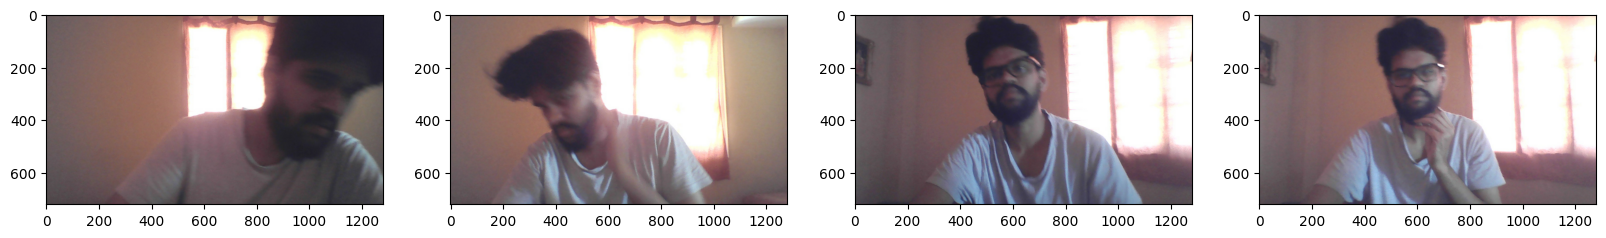

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [18]:
213*.7 # 150 to train

149.1

In [19]:
213*.15 # 32 and 31 to test and val

31.95

### 3.2 Move the Matching Labels

In [20]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [21]:
import albumentations as alb

In [22]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [23]:
img = cv2.imread(os.path.join('data','train', 'images','WIN_20220113_19_56_58_Pro (2).jpg'))

In [24]:
img.shape # 651=height, 653=wide, 3=channels deep

(651, 653, 3)

In [25]:
with open(os.path.join('data', 'train', 'labels', 'WIN_20220113_19_56_58_Pro (2).json'), 'r') as f:
    label = json.load(f)

In [26]:
label['shapes'][0]['points']

[[120.10902255639098, 11.21428571428573],
 [438.1541353383459, 398.4323308270677]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [27]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [28]:
coords

[120.10902255639098, 11.21428571428573, 438.1541353383459, 398.4323308270677]

In [29]:
coords = list(np.divide(coords, [640,480,640,480]))

In [30]:
coords

[0.18767034774436092,
 0.02336309523809527,
 0.6846158364661654,
 0.8300673558897244]

### 4.4 Apply Augmentations and View Results

In [31]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [32]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [33]:
augmented['bboxes'][0][2:]

(0.8410028064954052, 1.0)

In [34]:
augmented['bboxes']

[(0.11987968619465328, 0.018243055555555603, 0.8410028064954052, 1.0)]

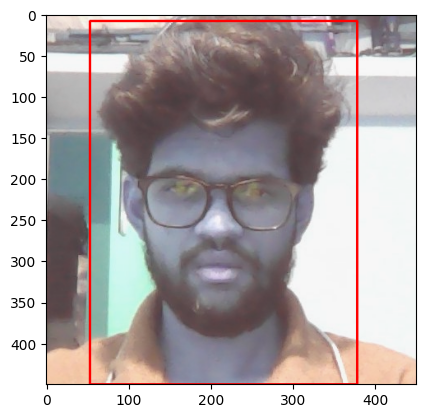

In [35]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [36]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected x_max for bbox [0.8300781250000002, 0.16319444444444448, 1.2975260416666667, 1.0000000000000002, 'face'] to be in the range [0.0, 1.0], got 1.2975260416666667.
Expected x_max for bbox [0.9351672535211268, 0.08211561032863847, 1.326892605633803, 0.858230633802817, 'face'] to be in the range [0.0, 1.0], got 1.326892605633803.
Expected x_max for bbox [0.9368489583333334, 0.21180555555555555, 1.3066406250000002, 0.9809027777777779, 'face'] to be in the range [0.0, 1.0], got 1.3066406250000002.
Expected x_max for bbox [0.7871093750000001, 0.22048611111111113, 1.2180989583333335, 0.920138888888889, 'face'] to be in the range [0.0, 1.0], got 1.2180989583333335.
Expected x_max for bbox [0.7063802083333333, 0.005208333333333333, 1.3795572916666667, 1.0694444444444444, 'face'] to be in the range [0.0, 1.0], got 1.3795572916666667.
Expected x_max for bbox [0.8300781250000002, 0.14062500000000003, 1.3977864583333335, 1.1614583333333333, 'face'] to be in the range [0.0, 1.0], got 1.3977864

Expected x_max for bbox [0.8235677083333334, 0.08506944444444445, 1.2975260416666667, 0.8767361111111112, 'face'] to be in the range [0.0, 1.0], got 1.2975260416666667.
Expected x_min for bbox [1.0423177083333335, 0.17881944444444448, 1.5332031250000002, 1.2708333333333333, 'face'] to be in the range [0.0, 1.0], got 1.0423177083333335.
Expected x_max for bbox [0.583984375, 0.08333333333333333, 1.1217447916666667, 0.8333333333333335, 'face'] to be in the range [0.0, 1.0], got 1.1217447916666667.
Expected x_max for bbox [0.630859375, 0.15104166666666669, 1.1425781250000002, 0.8993055555555556, 'face'] to be in the range [0.0, 1.0], got 1.1425781250000002.
Expected x_min for bbox [1.0084635416666667, 0.08333333333333333, 1.5618489583333335, 0.9340277777777779, 'face'] to be in the range [0.0, 1.0], got 1.0084635416666667.
Expected x_min for bbox [1.0253906250000002, 0.06597222222222222, 1.4394531250000002, 0.9739583333333335, 'face'] to be in the range [0.0, 1.0], got 1.0253906250000002.


Expected x_min for bbox [1.0410156250000002, 0.09027777777777778, 1.6100260416666667, 0.920138888888889, 'face'] to be in the range [0.0, 1.0], got 1.0410156250000002.
Expected x_max for bbox [0.9459635416666667, 0.05381944444444445, 1.4212239583333335, 1.0260416666666667, 'face'] to be in the range [0.0, 1.0], got 1.4212239583333335.
Expected x_max for bbox [0.685546875, 0.078125, 1.1074218750000002, 0.8923611111111112, 'face'] to be in the range [0.0, 1.0], got 1.1074218750000002.
Expected x_max for bbox [0.9173177083333334, 0.09895833333333333, 1.3470052083333335, 0.9739583333333335, 'face'] to be in the range [0.0, 1.0], got 1.3470052083333335.
Expected y_max for bbox [0.5006510416666667, 0.05729166666666667, 0.9928385416666667, 1.043402777777778, 'face'] to be in the range [0.0, 1.0], got 1.043402777777778.
Expected x_max for bbox [0.7024739583333333, 0.029513888888888888, 1.2467447916666667, 0.9947916666666667, 'face'] to be in the range [0.0, 1.0], got 1.2467447916666667.
Expect

Expected x_max for bbox [0.9003906250000002, 0.034722222222222224, 1.5618489583333335, 1.097222222222222, 'face'] to be in the range [0.0, 1.0], got 1.5618489583333335.
Expected x_max for bbox [0.8977864583333334, 0.03645833333333334, 1.619140625, 1.1770833333333333, 'face'] to be in the range [0.0, 1.0], got 1.619140625.
Expected x_min for bbox [1.3574218750000002, 0.022569444444444444, 1.9928385416666667, 1.2361111111111112, 'face'] to be in the range [0.0, 1.0], got 1.3574218750000002.
Expected x_min for bbox [1.2884114583333335, 0.02777777777777778, 1.9251302083333333, 1.137152777777778, 'face'] to be in the range [0.0, 1.0], got 1.2884114583333335.
Expected x_max for bbox [0.646484375, 0.029513888888888888, 1.3652343750000002, 1.0347222222222223, 'face'] to be in the range [0.0, 1.0], got 1.3652343750000002.
Expected x_max for bbox [0.3170572916666667, 0.022569444444444444, 1.1881510416666667, 1.1770833333333333, 'face'] to be in the range [0.0, 1.0], got 1.1881510416666667.
Expec

### 5.2 Load Augmented Images to Tensorflow Dataset

In [37]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [38]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [39]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [40]:
train_images.as_numpy_iterator().next()

array([[[0.5985907 , 0.6858456 , 0.856924  ],
        [0.60765934, 0.6978554 , 0.86237746],
        [0.6276348 , 0.7178309 , 0.8786152 ],
        ...,
        [0.59344363, 0.6836397 , 0.81697303],
        [0.6009804 , 0.6838235 , 0.81960785],
        [0.61268383, 0.6911152 , 0.8283701 ]],

       [[0.6333333 , 0.70931375, 0.8769608 ],
        [0.6283701 , 0.7185662 , 0.8793505 ],
        [0.63186276, 0.73039216, 0.8857843 ],
        ...,
        [0.5877451 , 0.6818628 , 0.8151961 ],
        [0.5912377 , 0.68235296, 0.8156863 ],
        [0.6041054 , 0.68694854, 0.82273287]],

       [[0.6137255 , 0.71139705, 0.8684436 ],
        [0.6318015 , 0.7298407 , 0.88670343],
        [0.6397059 , 0.72990197, 0.8906863 ],
        ...,
        [0.58523285, 0.6793505 , 0.8126838 ],
        [0.58480394, 0.6789216 , 0.8122549 ],
        [0.5901348 , 0.671875  , 0.81188726]],

       ...,

       [[0.1898897 , 0.13106617, 0.15851715],
        [0.18382353, 0.125     , 0.15147059],
        [0.17303921, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [41]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [42]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.     , 0.11694, 0.587  , 1.     ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [46]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(540, 540, 120, 120, 60, 60)

### 7.2 Create Final Datasets (Images/Labels)

In [47]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [48]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [49]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [50]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.02408, 0.     , 1.     , 1.     ],
        [0.     , 0.02888, 0.9365 , 1.     ],
        [0.     , 0.0972 , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.651  , 0.9688 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1418 , 0.     , 1.     , 1.     ]], dtype=float16))

### 7.3 View Images and Annotations

In [51]:
data_samples = train.as_numpy_iterator()

In [52]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


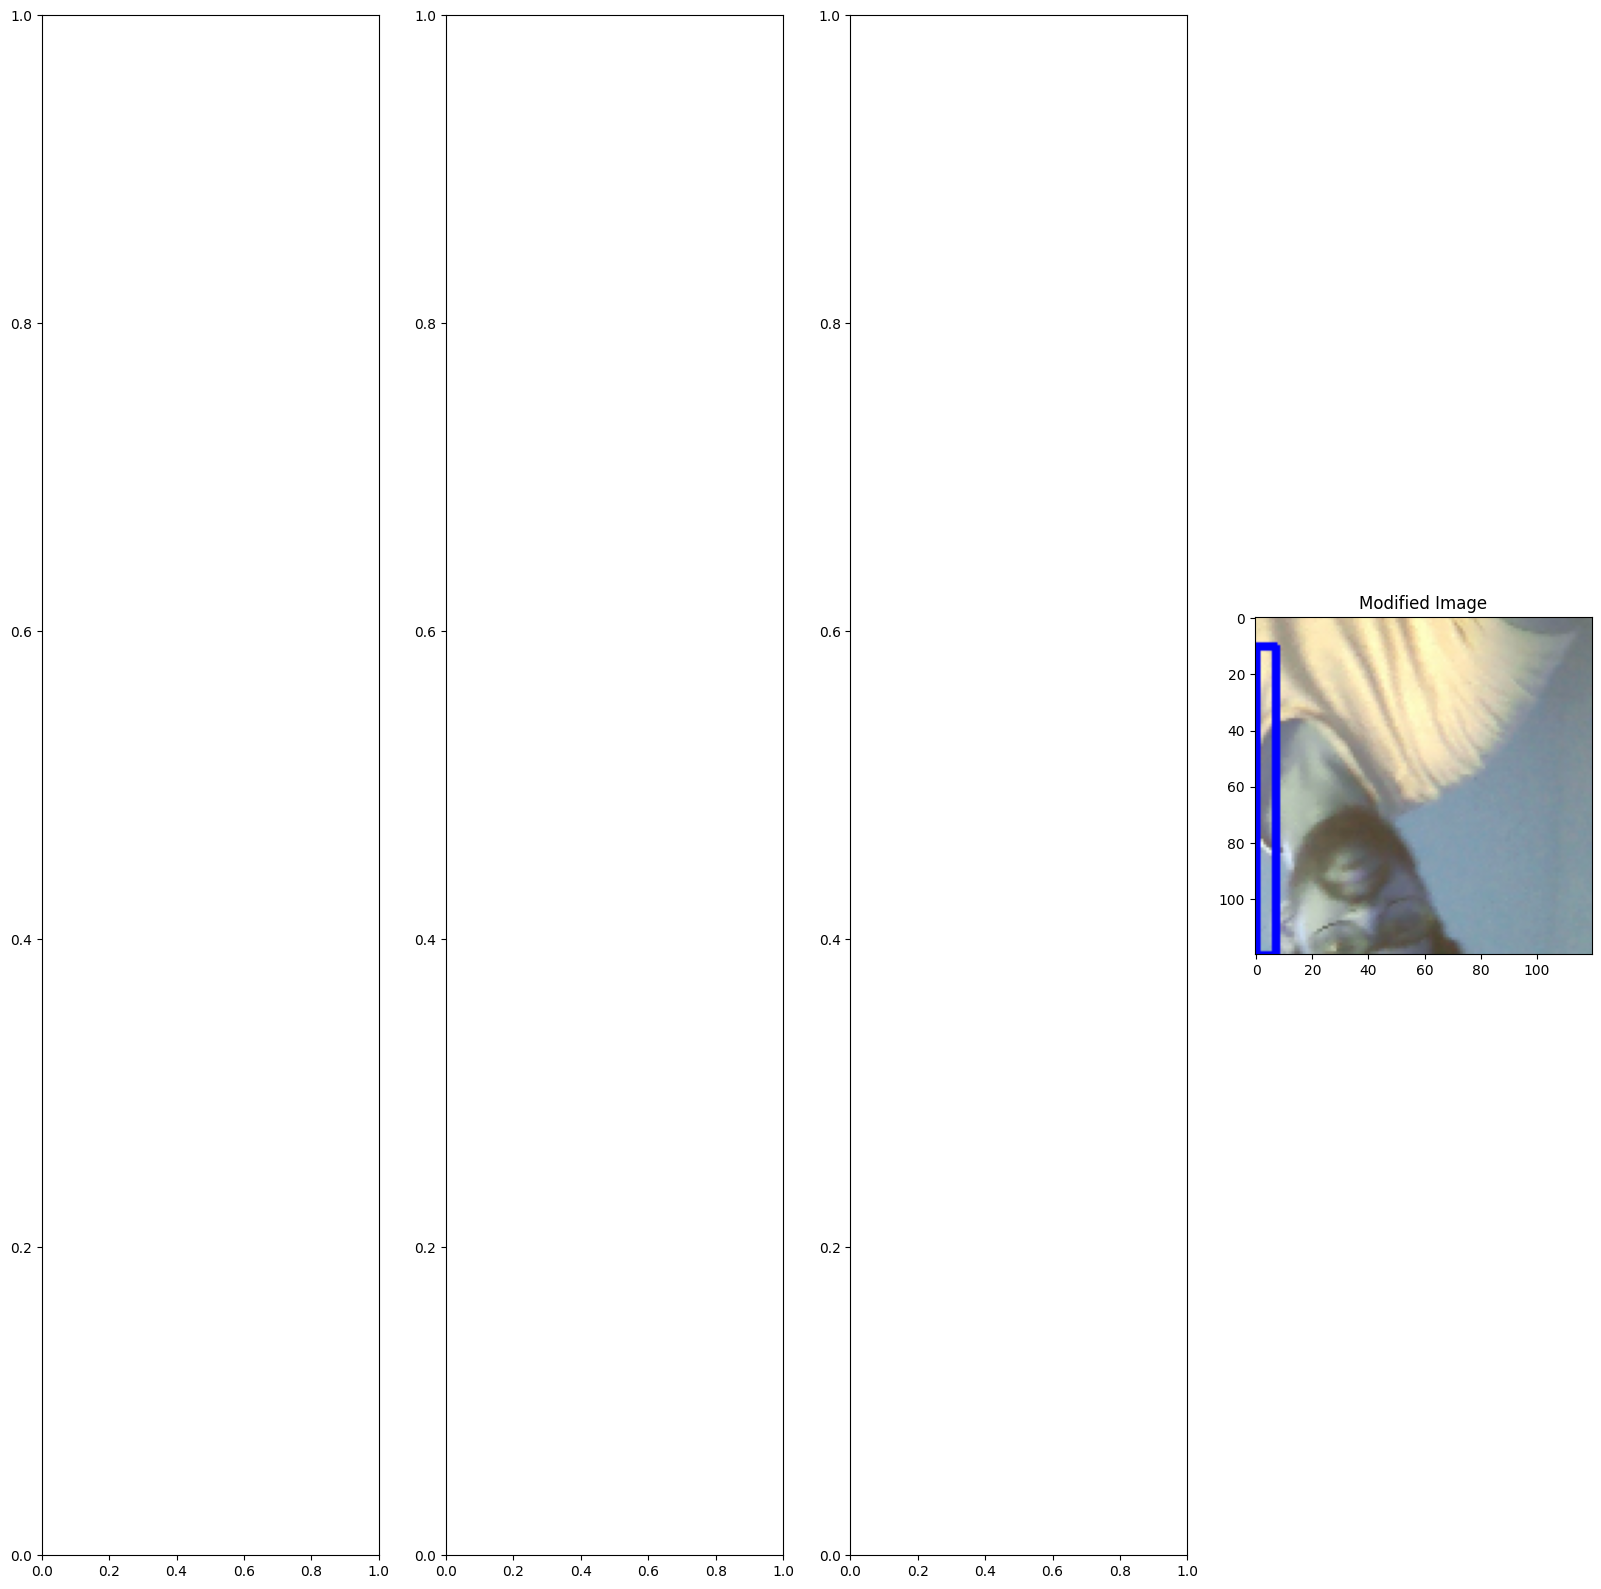

In [53]:

import numpy as np
import cv2

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

# Convert the NumPy array to a cv::UMat object
sample_image_umat = cv2.UMat(sample_image)

# Use cv2.UMat() for img argument in cv2.rectangle
cv2.rectangle(sample_image_umat, 
              tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
              (255, 0, 0), 2)

# Convert the modified cv::UMat object back to a NumPy array
sample_image_result = np.asarray(sample_image_umat.get())

# Display the result or perform further operations as needed
plt.imshow(cv2.cvtColor(sample_image_result, cv2.COLOR_BGR2RGB))
plt.title("Modified Image")
plt.show()


#sample_image_result_clipped = np.clip(sample_image_result, 0, 255).astype(np.uint8)

# Display the result using Matplotlib
#plt.imshow(cv2.cvtColor(sample_image_result_clipped, cv2.COLOR_BGR2RGB))
#plt.title("Modified Image")
#plt.show()

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [54]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [55]:
vgg = VGG16(include_top=False)

In [56]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [57]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [58]:
facetracker = build_model()

In [59]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [60]:
X, y = train.as_numpy_iterator().next()

In [61]:
X.shape

(8, 120, 120, 3)

In [62]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [63]:
classes, coords

(array([[0.4515486 ],
        [0.4559851 ],
        [0.46058294],
        [0.33853462],
        [0.45057   ],
        [0.4310987 ],
        [0.45586827],
        [0.50991625]], dtype=float32),
 array([[0.4327259 , 0.5464437 , 0.44349012, 0.5246954 ],
        [0.3916989 , 0.6317042 , 0.45256034, 0.6074865 ],
        [0.43652493, 0.5569748 , 0.4532326 , 0.55961597],
        [0.3279036 , 0.6903238 , 0.45747203, 0.606875  ],
        [0.448379  , 0.66915536, 0.41638923, 0.5477312 ],
        [0.38366583, 0.68979096, 0.4638974 , 0.63013893],
        [0.41617486, 0.6448173 , 0.41938794, 0.5855513 ],
        [0.42622274, 0.6610781 , 0.47017646, 0.56702363]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [64]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [65]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [66]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [67]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [68]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=12.747902>

In [69]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7973102>

In [70]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=12.747902>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [71]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [72]:
model = FaceTracker(facetracker)

In [73]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [74]:
logdir='logs'

In [75]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [76]:
hist = model.fit(train.take(100), epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
68/68 [==============================] - 124s 2s/step - total_loss: 2.5660 - class_loss: 0.3679 - regress_loss: 2.3820 - val_total_loss: 1.8952 - val_class_loss: 0.7294 - val_regress_loss: 1.5304
Epoch 2/10
68/68 [==============================] - 121s 2s/step - total_loss: 1.0942 - class_loss: 0.1891 - regress_loss: 0.9997 - val_total_loss: 1.4365 - val_class_loss: 1.1489e-05 - val_regress_loss: 1.4365
Epoch 3/10
68/68 [==============================] - 117s 2s/step - total_loss: 0.9133 - class_loss: 0.1591 - regress_loss: 0.8337 - val_total_loss: 0.5242 - val_class_loss: 0.1637 - val_regress_loss: 0.4423
Epoch 4/10
68/68 [==============================] - 118s 2s/step - total_loss: 0.7305 - class_loss: 0.1237 - regress_loss: 0.6686 - val_total_loss: 1.6568 - val_class_loss: 0.0048 - val_regress_loss: 1.6544
Epoch 5/10
68/68 [==============================] - 115s 2s/step - total_loss: 0.6137 - class_loss: 0.1182 - regress_loss: 0.5546 - val_total_loss: 0.3224 - val_class_l

### 10.3 Plot Performance

In [77]:
hist.history

{'total_loss': [0.4994194805622101,
  0.48847344517707825,
  0.3723078668117523,
  0.08529923856258392,
  0.5255849957466125,
  0.236497163772583,
  0.16978809237480164,
  0.11428394168615341,
  0.10537135601043701,
  0.15459436178207397],
 'class_loss': [0.1394084244966507,
  0.00404077023267746,
  0.011381166987121105,
  0.018637530505657196,
  0.22168730199337006,
  0.19878286123275757,
  3.874325102515286e-06,
  0.02236352488398552,
  0.0031010557431727648,
  6.288336862780852e-06],
 'regress_loss': [0.42971527576446533,
  0.4864530563354492,
  0.3666172921657562,
  0.07598047703504562,
  0.4147413372993469,
  0.13710573315620422,
  0.16978615522384644,
  0.1031021773815155,
  0.10382083058357239,
  0.15459121763706207],
 'val_total_loss': [1.895167350769043,
  1.4365086555480957,
  0.5241711735725403,
  1.6567654609680176,
  0.3224061131477356,
  0.9659740328788757,
  1.2363561391830444,
  0.9681146740913391,
  0.7505119442939758,
  2.3408734798431396],
 'val_class_loss': [0.72943

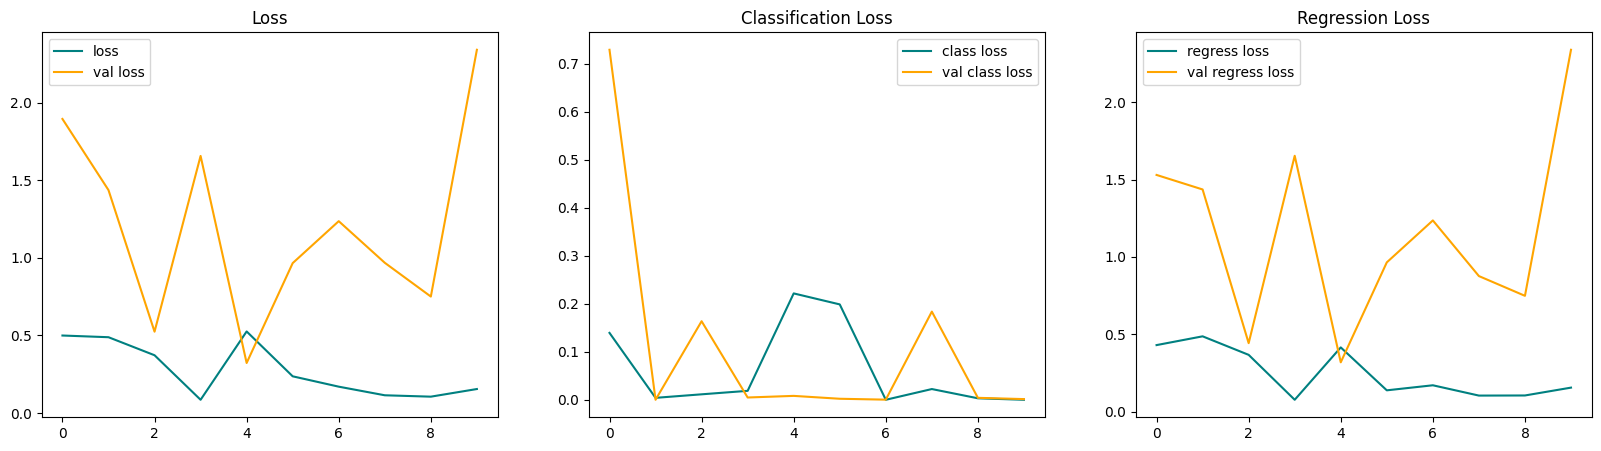

In [78]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [92]:
test_data = test.as_numpy_iterator()

In [93]:
test_sample = test_data.next()

In [94]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 262ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


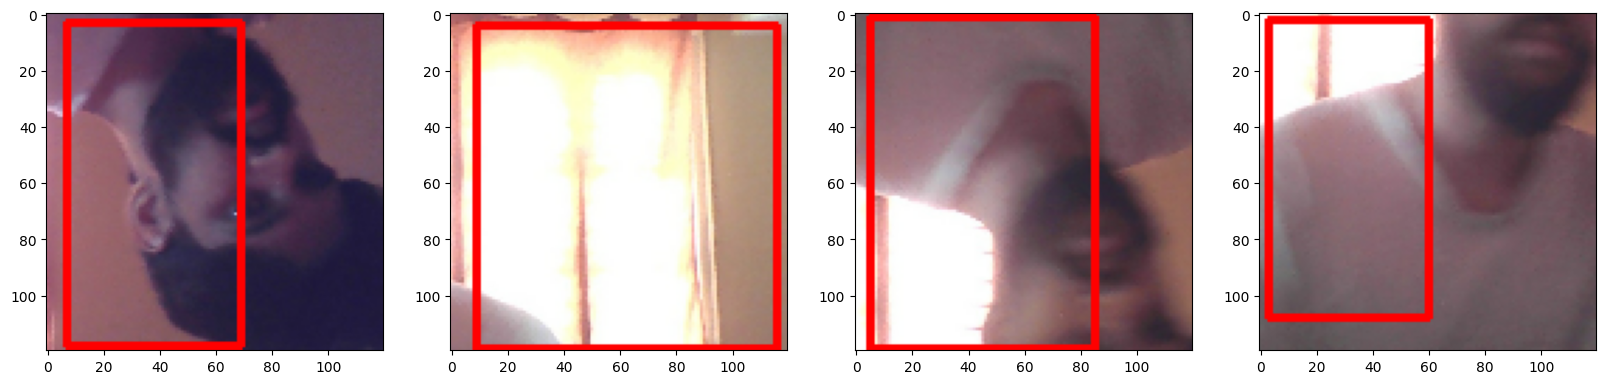

In [95]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        # Convert the NumPy array to a cv::UMat object
        sample_image_umat = cv2.UMat(sample_image)

        # Use cv2.UMat() for img argument in cv2.rectangle
        cv2.rectangle(sample_image_umat,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

        # Convert the modified cv::UMat object back to a NumPy array
        sample_image_result = np.asarray(sample_image_umat.get())

        ax[idx].imshow(sample_image_result)
    else:
        ax[idx].imshow(sample_image)

plt.show()


### 11.2 Save the Model

In [96]:
from tensorflow.keras.models import load_model

In [97]:
facetracker.save('facetracker.h5')

In [98]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [118]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.namedWindow('EyeTrack', cv2.WINDOW_NORMAL)
    #cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.waitKey(1)  # waits until a key is pressed
cv2.destroyWindow('EyeTrack')  # Replace 'EyeTrack' with your window name

TypeError: 'NoneType' object is not subscriptable

In [109]:
pip install opencv-python-headless


In [129]:
import cv2
import tensorflow as tf
import numpy as np

# Load the face tracking model (replace 'facetracker' with your actual model)
facetracker = tf.keras.models.load_model('C:/MY_FOLDER/DATA SCIENCE & ANALYST/FACE DETECTION/facedetection/Face Detection/facetracker.h5')

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    # If using a different camera index (e.g., 1), you can try switching the index.
    # cap = cv2.VideoCapture(1)
    exit()

while True:
    ret, frame = cap.read()

    if not ret:
        print("Error: Failed to capture frame.")
        break

    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))

    if yhat[0].shape[0] > 0:  # Check if there is at least one prediction
        sample_coords = yhat[0][0]  # Assuming the face coordinates are in the first element of the output

        if np.any(yhat[1][0] > 0.5):
            # Controls the main rectangle
            cv2.rectangle(frame,
                          tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                          (255, 0, 0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame,
                          tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                       [0, -30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                       [80, 0])),
                          (255, 0, 0), -1)

            # Controls the text rendered
            cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                    [0, -5])),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.namedWindow('EyeTrack', cv2.WINDOW_NORMAL)
    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()


Error: Failed to capture frame.
